#### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Exploring the TF-Hub CORD-19 Swivel Embeddings


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/cord_19_embeddings_keras"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/cord_19_embeddings_keras.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/cord_19_embeddings_keras.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/cord_19_embeddings_keras.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/tensorflow/cord-19/swivel-128d/3"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

The CORD-19 Swivel text embedding module from TF-Hub (https://tfhub.dev/tensorflow/cord-19/swivel-128d/3)
 was built to support researchers analyzing natural languages text related to COVID-19.
These embeddings were trained on the titles, authors, abstracts, body texts, and
reference titles of articles in the [CORD-19 dataset](https://api.semanticscholar.org/CorpusID:216056360).

In this colab we will:
- Analyze semantically similar words in the embedding space
- Train a classifier on the SciCite dataset using the CORD-19 embeddings


## Setup


In [2]:
import functools
import itertools
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_hub as hub

from tqdm import trange

# Analyze the embeddings

Let's start off by analyzing the embedding by calculating and plotting a correlation matrix between different terms. If the embedding learned to successfully capture the meaning of different words, the embedding vectors of semantically similar words should be close together. Let's take a look at some COVID-19 related terms.

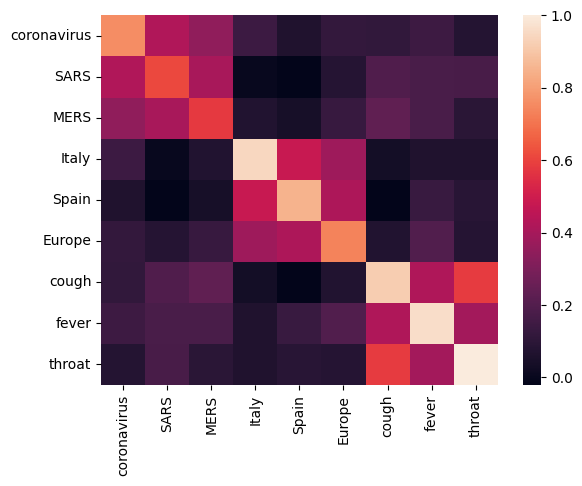

In [3]:
# Use the inner product between two embedding vectors as the similarity measure
def plot_correlation(labels, features):
  corr = np.inner(features, features)
  corr /= np.max(corr)
  sns.heatmap(corr, xticklabels=labels, yticklabels=labels)

# Generate embeddings for some terms
queries = [
  # Related viruses
  'coronavirus', 'SARS', 'MERS',
  # Regions
  'Italy', 'Spain', 'Europe',
  # Symptoms
  'cough', 'fever', 'throat'
]

module = hub.load('https://tfhub.dev/tensorflow/cord-19/swivel-128d/3')
embeddings = module(queries)

plot_correlation(queries, embeddings)

We can see that the embedding successfully captured the meaning of the different terms. Each word is similar to the other words of its cluster (i.e. "coronavirus" highly correlates with "SARS" and "MERS"), while they are different from terms of other clusters (i.e. the similarity between "SARS" and "Spain" is close to 0).

Now let's see how we can use these embeddings to solve a specific task.

## SciCite: Citation Intent Classification

This section shows how one can use the embedding for downstream tasks such as text classification. We'll use the [SciCite dataset](https://www.tensorflow.org/datasets/catalog/scicite) from TensorFlow Datasets to classify citation intents in academic papers. Given a sentence with a citation from an academic paper, classify whether the main intent of the citation is as background information, use of methods, or comparing results.

In [4]:
builder = tfds.builder(name='scicite')
builder.download_and_prepare()
train_data, validation_data, test_data = builder.as_dataset(
    split=('train', 'validation', 'test'),
    as_supervised=True)

In [5]:
#@title Let's take a look at a few labeled examples from the training set
NUM_EXAMPLES =   10#@param {type:"integer"}

TEXT_FEATURE_NAME = builder.info.supervised_keys[0]
LABEL_NAME = builder.info.supervised_keys[1]

def label2str(numeric_label):
  m = builder.info.features[LABEL_NAME].names
  return m[numeric_label]

data = next(iter(train_data.batch(NUM_EXAMPLES)))


pd.DataFrame({
    TEXT_FEATURE_NAME: [ex.numpy().decode('utf8') for ex in data[0]],
    LABEL_NAME: [label2str(x) for x in data[1]]
})

string       label
0  The finding that BMI is closely related to TBF...      result
1  The average magnitude of the NBR increases wit...  background
2  It has been reported that NF-κB activation can...      result
3  , 2008; Quraan and Cheyne, 2008; Quraan and Ch...  background
4  5B), but, interestingly, they shared conserved...  background
5  Some investigators have noted an association o...  background
6  In our previous study, it is documented that b...  background
7  These subjects have intact cognitive function ...  background
8  Another study reported improved knee function ...  background
9  C. Data Analysis Transcription Speech samples ...      method

## Training a citaton intent classifier

We'll train a classifier on the [SciCite dataset](https://www.tensorflow.org/datasets/catalog/scicite) using Keras.  Let's build a model which use the CORD-19 embeddings with a classification layer on top.

In [6]:
#@title Hyperparameters { run: "auto" }

EMBEDDING = 'https://tfhub.dev/tensorflow/cord-19/swivel-128d/3'  #@param {type: "string"}
TRAINABLE_MODULE = False  #@param {type: "boolean"}

hub_layer = hub.KerasLayer(EMBEDDING, input_shape=[], 
                           dtype=tf.string, trainable=TRAINABLE_MODULE)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(3))
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 keras_layer (KerasLayer)    (None, 128)               17301632  


 dense (Dense)               (None, 3)                 387       


Total params: 17302019 (132.00 MB)


Trainable params: 387 (1.51 KB)


Non-trainable params: 17301632 (132.00 MB)


_________________________________________________________________


## Train and evaluate the model

Let's train and evaluate the model to see the performance on the SciCite task

In [7]:
EPOCHS = 35#@param {type: "integer"}
BATCH_SIZE = 32#@param {type: "integer"}

history = model.fit(train_data.shuffle(10000).batch(BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data=validation_data.batch(BATCH_SIZE),
                    verbose=1)

Epoch 1/35


  1/257 [..............................] - ETA: 6:48 - loss: 1.3518 - accuracy: 0.1875

 16/257 [>.............................] - ETA: 0s - loss: 1.2391 - accuracy: 0.2832  

 33/257 [==>...........................] - ETA: 0s - loss: 1.1511 - accuracy: 0.3665

 50/257 [====>.........................] - ETA: 0s - loss: 1.0873 - accuracy: 0.4306

 66/257 [======>.......................] - ETA: 0s - loss: 1.0461 - accuracy: 0.4735

 83/257 [========>.....................] - ETA: 0s - loss: 1.0185 - accuracy: 0.4977

100/257 [==========>...................] - ETA: 0s - loss: 0.9951 - accuracy: 0.5203

117/257 [============>.................] - ETA: 0s - loss: 0.9724 - accuracy: 0.5414

134/257 [==============>...............] - ETA: 0s - loss: 0.9596 - accuracy: 0.5536

151/257 [================>.............] - ETA: 0s - loss: 0.9482 - accuracy: 0.5650

168/257 [==================>...........] - ETA: 0s - loss: 0.9340 - accuracy: 0.5746

185/257 [====================>.........] - ETA: 0s - loss: 0.9192 - accuracy: 0.5858

202/257 [======================>.......] - ETA: 0s - loss: 0.9044 - accuracy: 0.5959

219/257 [========================>.....] - ETA: 0s - loss: 0.8986 - accuracy: 0.5977

236/257 [==========================>...] - ETA: 0s - loss: 0.8867 - accuracy: 0.6058

253/257 [============================>.] - ETA: 0s - loss: 0.8769 - accuracy: 0.6135

257/257 [==============================] - 3s 5ms/step - loss: 0.8760 - accuracy: 0.6140 - val_loss: 0.7403 - val_accuracy: 0.7227


Epoch 2/35


  1/257 [..............................] - ETA: 1:23 - loss: 0.8620 - accuracy: 0.5938

 17/257 [>.............................] - ETA: 0s - loss: 0.7541 - accuracy: 0.6801  

 34/257 [==>...........................] - ETA: 0s - loss: 0.7513 - accuracy: 0.6875

 51/257 [====>.........................] - ETA: 0s - loss: 0.7426 - accuracy: 0.6967

 68/257 [======>.......................] - ETA: 0s - loss: 0.7395 - accuracy: 0.6939

 85/257 [========>.....................] - ETA: 0s - loss: 0.7314 - accuracy: 0.7018

102/257 [==========>...................] - ETA: 0s - loss: 0.7262 - accuracy: 0.7059

120/257 [=============>................] - ETA: 0s - loss: 0.7197 - accuracy: 0.7091

137/257 [==============>...............] - ETA: 0s - loss: 0.7196 - accuracy: 0.7108

154/257 [================>.............] - ETA: 0s - loss: 0.7092 - accuracy: 0.7177

171/257 [==================>...........] - ETA: 0s - loss: 0.7049 - accuracy: 0.7195

188/257 [====================>.........] - ETA: 0s - loss: 0.6996 - accuracy: 0.7222

205/257 [======================>.......] - ETA: 0s - loss: 0.6944 - accuracy: 0.7236

222/257 [========================>.....] - ETA: 0s - loss: 0.6923 - accuracy: 0.7242

240/257 [===========================>..] - ETA: 0s - loss: 0.6896 - accuracy: 0.7249

257/257 [==============================] - ETA: 0s - loss: 0.6880 - accuracy: 0.7259

257/257 [==============================] - 1s 4ms/step - loss: 0.6880 - accuracy: 0.7259 - val_loss: 0.6526 - val_accuracy: 0.7555


Epoch 3/35


  1/257 [..............................] - ETA: 1:11 - loss: 0.7175 - accuracy: 0.6562

 17/257 [>.............................] - ETA: 0s - loss: 0.6663 - accuracy: 0.7132  

 34/257 [==>...........................] - ETA: 0s - loss: 0.6494 - accuracy: 0.7362

 52/257 [=====>........................] - ETA: 0s - loss: 0.6486 - accuracy: 0.7356

 69/257 [=======>......................] - ETA: 0s - loss: 0.6308 - accuracy: 0.7536

 86/257 [=========>....................] - ETA: 0s - loss: 0.6335 - accuracy: 0.7518

103/257 [===========>..................] - ETA: 0s - loss: 0.6378 - accuracy: 0.7485

120/257 [=============>................] - ETA: 0s - loss: 0.6324 - accuracy: 0.7523

137/257 [==============>...............] - ETA: 0s - loss: 0.6303 - accuracy: 0.7546

154/257 [================>.............] - ETA: 0s - loss: 0.6265 - accuracy: 0.7553

170/257 [==================>...........] - ETA: 0s - loss: 0.6299 - accuracy: 0.7526

186/257 [====================>.........] - ETA: 0s - loss: 0.6236 - accuracy: 0.7560

203/257 [======================>.......] - ETA: 0s - loss: 0.6223 - accuracy: 0.7574

219/257 [========================>.....] - ETA: 0s - loss: 0.6211 - accuracy: 0.7586

236/257 [==========================>...] - ETA: 0s - loss: 0.6175 - accuracy: 0.7595

253/257 [============================>.] - ETA: 0s - loss: 0.6211 - accuracy: 0.7574

257/257 [==============================] - 1s 4ms/step - loss: 0.6211 - accuracy: 0.7575 - val_loss: 0.6142 - val_accuracy: 0.7598


Epoch 4/35


  1/257 [..............................] - ETA: 1:14 - loss: 0.7404 - accuracy: 0.5938

 17/257 [>.............................] - ETA: 0s - loss: 0.6005 - accuracy: 0.7537  

 34/257 [==>...........................] - ETA: 0s - loss: 0.6058 - accuracy: 0.7619

 51/257 [====>.........................] - ETA: 0s - loss: 0.6244 - accuracy: 0.7531

 68/257 [======>.......................] - ETA: 0s - loss: 0.6084 - accuracy: 0.7574

 84/257 [========>.....................] - ETA: 0s - loss: 0.6053 - accuracy: 0.7571

101/257 [==========>...................] - ETA: 0s - loss: 0.6041 - accuracy: 0.7608

117/257 [============>.................] - ETA: 0s - loss: 0.6018 - accuracy: 0.7658

134/257 [==============>...............] - ETA: 0s - loss: 0.6009 - accuracy: 0.7659

151/257 [================>.............] - ETA: 0s - loss: 0.5938 - accuracy: 0.7682

167/257 [==================>...........] - ETA: 0s - loss: 0.5956 - accuracy: 0.7657

184/257 [====================>.........] - ETA: 0s - loss: 0.5927 - accuracy: 0.7673

200/257 [======================>.......] - ETA: 0s - loss: 0.5939 - accuracy: 0.7667

217/257 [========================>.....] - ETA: 0s - loss: 0.5905 - accuracy: 0.7689

233/257 [==========================>...] - ETA: 0s - loss: 0.5884 - accuracy: 0.7708

249/257 [============================>.] - ETA: 0s - loss: 0.5846 - accuracy: 0.7736

257/257 [==============================] - 1s 4ms/step - loss: 0.5870 - accuracy: 0.7720 - val_loss: 0.5962 - val_accuracy: 0.7609


Epoch 5/35


  1/257 [..............................] - ETA: 2:08 - loss: 0.5937 - accuracy: 0.8125

 17/257 [>.............................] - ETA: 0s - loss: 0.5881 - accuracy: 0.7702  

 33/257 [==>...........................] - ETA: 0s - loss: 0.5773 - accuracy: 0.7841

 50/257 [====>.........................] - ETA: 0s - loss: 0.5701 - accuracy: 0.7837

 66/257 [======>.......................] - ETA: 0s - loss: 0.5675 - accuracy: 0.7874

 83/257 [========>.....................] - ETA: 0s - loss: 0.5643 - accuracy: 0.7873

100/257 [==========>...................] - ETA: 0s - loss: 0.5703 - accuracy: 0.7831

116/257 [============>.................] - ETA: 0s - loss: 0.5704 - accuracy: 0.7810

132/257 [==============>...............] - ETA: 0s - loss: 0.5721 - accuracy: 0.7779

148/257 [================>.............] - ETA: 0s - loss: 0.5686 - accuracy: 0.7796

164/257 [==================>...........] - ETA: 0s - loss: 0.5687 - accuracy: 0.7803

180/257 [====================>.........] - ETA: 0s - loss: 0.5649 - accuracy: 0.7825

196/257 [=====================>........] - ETA: 0s - loss: 0.5665 - accuracy: 0.7817

212/257 [=======================>......] - ETA: 0s - loss: 0.5709 - accuracy: 0.7774

228/257 [=========================>....] - ETA: 0s - loss: 0.5687 - accuracy: 0.7792

244/257 [===========================>..] - ETA: 0s - loss: 0.5685 - accuracy: 0.7798

257/257 [==============================] - 2s 4ms/step - loss: 0.5675 - accuracy: 0.7812 - val_loss: 0.5818 - val_accuracy: 0.7609


Epoch 6/35


  1/257 [..............................] - ETA: 1:36 - loss: 0.4456 - accuracy: 0.8750

 17/257 [>.............................] - ETA: 0s - loss: 0.5618 - accuracy: 0.7794  

 34/257 [==>...........................] - ETA: 0s - loss: 0.5435 - accuracy: 0.7904

 51/257 [====>.........................] - ETA: 0s - loss: 0.5454 - accuracy: 0.7935

 67/257 [======>.......................] - ETA: 0s - loss: 0.5376 - accuracy: 0.7938

 84/257 [========>.....................] - ETA: 0s - loss: 0.5452 - accuracy: 0.7909

100/257 [==========>...................] - ETA: 0s - loss: 0.5464 - accuracy: 0.7887

116/257 [============>.................] - ETA: 0s - loss: 0.5422 - accuracy: 0.7893

133/257 [==============>...............] - ETA: 0s - loss: 0.5467 - accuracy: 0.7881

150/257 [================>.............] - ETA: 0s - loss: 0.5468 - accuracy: 0.7892

167/257 [==================>...........] - ETA: 0s - loss: 0.5410 - accuracy: 0.7932

184/257 [====================>.........] - ETA: 0s - loss: 0.5444 - accuracy: 0.7906

201/257 [======================>.......] - ETA: 0s - loss: 0.5457 - accuracy: 0.7904

218/257 [========================>.....] - ETA: 0s - loss: 0.5519 - accuracy: 0.7880

235/257 [==========================>...] - ETA: 0s - loss: 0.5511 - accuracy: 0.7874

252/257 [============================>.] - ETA: 0s - loss: 0.5540 - accuracy: 0.7860

257/257 [==============================] - 1s 4ms/step - loss: 0.5553 - accuracy: 0.7856 - val_loss: 0.5755 - val_accuracy: 0.7675


Epoch 7/35


  1/257 [..............................] - ETA: 1:17 - loss: 0.5275 - accuracy: 0.8750

 17/257 [>.............................] - ETA: 0s - loss: 0.5177 - accuracy: 0.8107  

 33/257 [==>...........................] - ETA: 0s - loss: 0.5358 - accuracy: 0.8049

 49/257 [====>.........................] - ETA: 0s - loss: 0.5355 - accuracy: 0.8042

 66/257 [======>.......................] - ETA: 0s - loss: 0.5412 - accuracy: 0.7988

 83/257 [========>.....................] - ETA: 0s - loss: 0.5449 - accuracy: 0.7941

100/257 [==========>...................] - ETA: 0s - loss: 0.5379 - accuracy: 0.7959

117/257 [============>.................] - ETA: 0s - loss: 0.5370 - accuracy: 0.7949

134/257 [==============>...............] - ETA: 0s - loss: 0.5345 - accuracy: 0.7938

150/257 [================>.............] - ETA: 0s - loss: 0.5381 - accuracy: 0.7919

166/257 [==================>...........] - ETA: 0s - loss: 0.5448 - accuracy: 0.7895

183/257 [====================>.........] - ETA: 0s - loss: 0.5430 - accuracy: 0.7905

199/257 [======================>.......] - ETA: 0s - loss: 0.5428 - accuracy: 0.7885

216/257 [========================>.....] - ETA: 0s - loss: 0.5427 - accuracy: 0.7898

233/257 [==========================>...] - ETA: 0s - loss: 0.5444 - accuracy: 0.7901

250/257 [============================>.] - ETA: 0s - loss: 0.5450 - accuracy: 0.7893

257/257 [==============================] - 1s 4ms/step - loss: 0.5461 - accuracy: 0.7889 - val_loss: 0.5697 - val_accuracy: 0.7707


Epoch 8/35


  1/257 [..............................] - ETA: 1:15 - loss: 0.4263 - accuracy: 0.8125

 18/257 [=>............................] - ETA: 0s - loss: 0.5350 - accuracy: 0.8003  

 35/257 [===>..........................] - ETA: 0s - loss: 0.5359 - accuracy: 0.8045

 52/257 [=====>........................] - ETA: 0s - loss: 0.5319 - accuracy: 0.8035

 70/257 [=======>......................] - ETA: 0s - loss: 0.5496 - accuracy: 0.7924

 88/257 [=========>....................] - ETA: 0s - loss: 0.5445 - accuracy: 0.7962

106/257 [===========>..................] - ETA: 0s - loss: 0.5439 - accuracy: 0.7954

123/257 [=============>................] - ETA: 0s - loss: 0.5429 - accuracy: 0.7932

140/257 [===============>..............] - ETA: 0s - loss: 0.5372 - accuracy: 0.7949

158/257 [=================>............] - ETA: 0s - loss: 0.5353 - accuracy: 0.7969

176/257 [===================>..........] - ETA: 0s - loss: 0.5369 - accuracy: 0.7942

194/257 [=====================>........] - ETA: 0s - loss: 0.5354 - accuracy: 0.7959

212/257 [=======================>......] - ETA: 0s - loss: 0.5404 - accuracy: 0.7932

230/257 [=========================>....] - ETA: 0s - loss: 0.5387 - accuracy: 0.7946

248/257 [===========================>..] - ETA: 0s - loss: 0.5384 - accuracy: 0.7944

257/257 [==============================] - 1s 4ms/step - loss: 0.5394 - accuracy: 0.7934 - val_loss: 0.5633 - val_accuracy: 0.7762


Epoch 9/35


  1/257 [..............................] - ETA: 1:18 - loss: 0.5482 - accuracy: 0.8438

 17/257 [>.............................] - ETA: 0s - loss: 0.5094 - accuracy: 0.8125  

 34/257 [==>...........................] - ETA: 0s - loss: 0.5344 - accuracy: 0.8088

 51/257 [====>.........................] - ETA: 0s - loss: 0.5479 - accuracy: 0.8015

 68/257 [======>.......................] - ETA: 0s - loss: 0.5615 - accuracy: 0.7932

 85/257 [========>.....................] - ETA: 0s - loss: 0.5569 - accuracy: 0.7930

102/257 [==========>...................] - ETA: 0s - loss: 0.5526 - accuracy: 0.7926

119/257 [============>.................] - ETA: 0s - loss: 0.5486 - accuracy: 0.7915

136/257 [==============>...............] - ETA: 0s - loss: 0.5464 - accuracy: 0.7904

153/257 [================>.............] - ETA: 0s - loss: 0.5442 - accuracy: 0.7906

170/257 [==================>...........] - ETA: 0s - loss: 0.5419 - accuracy: 0.7915

187/257 [====================>.........] - ETA: 0s - loss: 0.5417 - accuracy: 0.7909

204/257 [======================>.......] - ETA: 0s - loss: 0.5398 - accuracy: 0.7926

221/257 [========================>.....] - ETA: 0s - loss: 0.5375 - accuracy: 0.7933

238/257 [==========================>...] - ETA: 0s - loss: 0.5346 - accuracy: 0.7958

255/257 [============================>.] - ETA: 0s - loss: 0.5341 - accuracy: 0.7956

257/257 [==============================] - 1s 4ms/step - loss: 0.5339 - accuracy: 0.7955 - val_loss: 0.5620 - val_accuracy: 0.7773


Epoch 10/35


  1/257 [..............................] - ETA: 2:27 - loss: 0.6734 - accuracy: 0.6875

 17/257 [>.............................] - ETA: 0s - loss: 0.5636 - accuracy: 0.7831  

 34/257 [==>...........................] - ETA: 0s - loss: 0.5147 - accuracy: 0.8024

 51/257 [====>.........................] - ETA: 0s - loss: 0.5174 - accuracy: 0.8027

 68/257 [======>.......................] - ETA: 0s - loss: 0.5132 - accuracy: 0.8038

 85/257 [========>.....................] - ETA: 0s - loss: 0.5116 - accuracy: 0.8048

102/257 [==========>...................] - ETA: 0s - loss: 0.5146 - accuracy: 0.8048

119/257 [============>.................] - ETA: 0s - loss: 0.5228 - accuracy: 0.7996

136/257 [==============>...............] - ETA: 0s - loss: 0.5201 - accuracy: 0.8006

153/257 [================>.............] - ETA: 0s - loss: 0.5181 - accuracy: 0.8033

170/257 [==================>...........] - ETA: 0s - loss: 0.5221 - accuracy: 0.8013

187/257 [====================>.........] - ETA: 0s - loss: 0.5246 - accuracy: 0.7998

204/257 [======================>.......] - ETA: 0s - loss: 0.5300 - accuracy: 0.7963

221/257 [========================>.....] - ETA: 0s - loss: 0.5292 - accuracy: 0.7950

238/257 [==========================>...] - ETA: 0s - loss: 0.5278 - accuracy: 0.7953

255/257 [============================>.] - ETA: 0s - loss: 0.5288 - accuracy: 0.7951

257/257 [==============================] - 2s 4ms/step - loss: 0.5294 - accuracy: 0.7950 - val_loss: 0.5582 - val_accuracy: 0.7740


Epoch 11/35


  1/257 [..............................] - ETA: 1:18 - loss: 0.5308 - accuracy: 0.7812

 17/257 [>.............................] - ETA: 0s - loss: 0.5484 - accuracy: 0.7739  

 34/257 [==>...........................] - ETA: 0s - loss: 0.5361 - accuracy: 0.7849

 51/257 [====>.........................] - ETA: 0s - loss: 0.5193 - accuracy: 0.7966

 68/257 [======>.......................] - ETA: 0s - loss: 0.5192 - accuracy: 0.7987

 85/257 [========>.....................] - ETA: 0s - loss: 0.5066 - accuracy: 0.8029

102/257 [==========>...................] - ETA: 0s - loss: 0.5061 - accuracy: 0.8036

119/257 [============>.................] - ETA: 0s - loss: 0.5123 - accuracy: 0.7999

136/257 [==============>...............] - ETA: 0s - loss: 0.5254 - accuracy: 0.7948

153/257 [================>.............] - ETA: 0s - loss: 0.5263 - accuracy: 0.7962

170/257 [==================>...........] - ETA: 0s - loss: 0.5267 - accuracy: 0.7954

187/257 [====================>.........] - ETA: 0s - loss: 0.5320 - accuracy: 0.7911

204/257 [======================>.......] - ETA: 0s - loss: 0.5311 - accuracy: 0.7911

220/257 [========================>.....] - ETA: 0s - loss: 0.5313 - accuracy: 0.7923

237/257 [==========================>...] - ETA: 0s - loss: 0.5272 - accuracy: 0.7946

254/257 [============================>.] - ETA: 0s - loss: 0.5254 - accuracy: 0.7954

257/257 [==============================] - 1s 4ms/step - loss: 0.5263 - accuracy: 0.7948 - val_loss: 0.5565 - val_accuracy: 0.7773


Epoch 12/35


  1/257 [..............................] - ETA: 1:18 - loss: 0.3245 - accuracy: 0.9062

 17/257 [>.............................] - ETA: 0s - loss: 0.5020 - accuracy: 0.7960  

 34/257 [==>...........................] - ETA: 0s - loss: 0.5072 - accuracy: 0.8024

 51/257 [====>.........................] - ETA: 0s - loss: 0.5040 - accuracy: 0.8051

 68/257 [======>.......................] - ETA: 0s - loss: 0.5176 - accuracy: 0.7964

 85/257 [========>.....................] - ETA: 0s - loss: 0.5272 - accuracy: 0.7930

102/257 [==========>...................] - ETA: 0s - loss: 0.5279 - accuracy: 0.7932

119/257 [============>.................] - ETA: 0s - loss: 0.5268 - accuracy: 0.7941

136/257 [==============>...............] - ETA: 0s - loss: 0.5261 - accuracy: 0.7941

152/257 [================>.............] - ETA: 0s - loss: 0.5249 - accuracy: 0.7946

168/257 [==================>...........] - ETA: 0s - loss: 0.5222 - accuracy: 0.7976

184/257 [====================>.........] - ETA: 0s - loss: 0.5220 - accuracy: 0.7976

201/257 [======================>.......] - ETA: 0s - loss: 0.5245 - accuracy: 0.7946

218/257 [========================>.....] - ETA: 0s - loss: 0.5213 - accuracy: 0.7947

235/257 [==========================>...] - ETA: 0s - loss: 0.5231 - accuracy: 0.7949

251/257 [============================>.] - ETA: 0s - loss: 0.5239 - accuracy: 0.7937

257/257 [==============================] - 1s 4ms/step - loss: 0.5233 - accuracy: 0.7941 - val_loss: 0.5547 - val_accuracy: 0.7784


Epoch 13/35


  1/257 [..............................] - ETA: 1:25 - loss: 0.4330 - accuracy: 0.8750

 16/257 [>.............................] - ETA: 0s - loss: 0.5284 - accuracy: 0.7852  

 32/257 [==>...........................] - ETA: 0s - loss: 0.5458 - accuracy: 0.7744

 48/257 [====>.........................] - ETA: 0s - loss: 0.5325 - accuracy: 0.7884

 64/257 [======>.......................] - ETA: 0s - loss: 0.5225 - accuracy: 0.7900

 80/257 [========>.....................] - ETA: 0s - loss: 0.5233 - accuracy: 0.7887

 96/257 [==========>...................] - ETA: 0s - loss: 0.5238 - accuracy: 0.7871

113/257 [============>.................] - ETA: 0s - loss: 0.5286 - accuracy: 0.7887

130/257 [==============>...............] - ETA: 0s - loss: 0.5250 - accuracy: 0.7899

147/257 [================>.............] - ETA: 0s - loss: 0.5204 - accuracy: 0.7944

164/257 [==================>...........] - ETA: 0s - loss: 0.5181 - accuracy: 0.7978

181/257 [====================>.........] - ETA: 0s - loss: 0.5154 - accuracy: 0.7977

198/257 [======================>.......] - ETA: 0s - loss: 0.5186 - accuracy: 0.7969

215/257 [========================>.....] - ETA: 0s - loss: 0.5198 - accuracy: 0.7956

232/257 [==========================>...] - ETA: 0s - loss: 0.5209 - accuracy: 0.7951

250/257 [============================>.] - ETA: 0s - loss: 0.5192 - accuracy: 0.7962

257/257 [==============================] - 1s 4ms/step - loss: 0.5206 - accuracy: 0.7958 - val_loss: 0.5538 - val_accuracy: 0.7740


Epoch 14/35


  1/257 [..............................] - ETA: 1:25 - loss: 0.5623 - accuracy: 0.7812

 17/257 [>.............................] - ETA: 0s - loss: 0.4970 - accuracy: 0.7960  

 34/257 [==>...........................] - ETA: 0s - loss: 0.5127 - accuracy: 0.7895

 51/257 [====>.........................] - ETA: 0s - loss: 0.5034 - accuracy: 0.7947

 68/257 [======>.......................] - ETA: 0s - loss: 0.5131 - accuracy: 0.7946

 85/257 [========>.....................] - ETA: 0s - loss: 0.5158 - accuracy: 0.7923

102/257 [==========>...................] - ETA: 0s - loss: 0.5171 - accuracy: 0.7926

119/257 [============>.................] - ETA: 0s - loss: 0.5169 - accuracy: 0.7925

136/257 [==============>...............] - ETA: 0s - loss: 0.5166 - accuracy: 0.7939

153/257 [================>.............] - ETA: 0s - loss: 0.5153 - accuracy: 0.7933

170/257 [==================>...........] - ETA: 0s - loss: 0.5162 - accuracy: 0.7932

187/257 [====================>.........] - ETA: 0s - loss: 0.5194 - accuracy: 0.7936

204/257 [======================>.......] - ETA: 0s - loss: 0.5184 - accuracy: 0.7926

221/257 [========================>.....] - ETA: 0s - loss: 0.5174 - accuracy: 0.7941

238/257 [==========================>...] - ETA: 0s - loss: 0.5183 - accuracy: 0.7936

255/257 [============================>.] - ETA: 0s - loss: 0.5183 - accuracy: 0.7944

257/257 [==============================] - 1s 4ms/step - loss: 0.5185 - accuracy: 0.7942 - val_loss: 0.5513 - val_accuracy: 0.7740


Epoch 15/35


  1/257 [..............................] - ETA: 1:20 - loss: 0.5099 - accuracy: 0.7812

 17/257 [>.............................] - ETA: 0s - loss: 0.5112 - accuracy: 0.8088  

 34/257 [==>...........................] - ETA: 0s - loss: 0.5373 - accuracy: 0.7914

 51/257 [====>.........................] - ETA: 0s - loss: 0.5364 - accuracy: 0.7880

 69/257 [=======>......................] - ETA: 0s - loss: 0.5254 - accuracy: 0.7921

 87/257 [=========>....................] - ETA: 0s - loss: 0.5311 - accuracy: 0.7906

105/257 [===========>..................] - ETA: 0s - loss: 0.5191 - accuracy: 0.7997

122/257 [=============>................] - ETA: 0s - loss: 0.5213 - accuracy: 0.7982

139/257 [===============>..............] - ETA: 0s - loss: 0.5174 - accuracy: 0.8024

156/257 [=================>............] - ETA: 0s - loss: 0.5174 - accuracy: 0.8017

174/257 [===================>..........] - ETA: 0s - loss: 0.5161 - accuracy: 0.8005

192/257 [=====================>........] - ETA: 0s - loss: 0.5172 - accuracy: 0.7970

210/257 [=======================>......] - ETA: 0s - loss: 0.5146 - accuracy: 0.7978

227/257 [=========================>....] - ETA: 0s - loss: 0.5147 - accuracy: 0.7980

244/257 [===========================>..] - ETA: 0s - loss: 0.5157 - accuracy: 0.7970

257/257 [==============================] - 1s 4ms/step - loss: 0.5164 - accuracy: 0.7968 - val_loss: 0.5509 - val_accuracy: 0.7740


Epoch 16/35


  1/257 [..............................] - ETA: 1:18 - loss: 0.5980 - accuracy: 0.7812

 17/257 [>.............................] - ETA: 0s - loss: 0.6023 - accuracy: 0.7592  

 34/257 [==>...........................] - ETA: 0s - loss: 0.5365 - accuracy: 0.7941

 51/257 [====>.........................] - ETA: 0s - loss: 0.5202 - accuracy: 0.8045

 68/257 [======>.......................] - ETA: 0s - loss: 0.5214 - accuracy: 0.8033

 85/257 [========>.....................] - ETA: 0s - loss: 0.5159 - accuracy: 0.8029

102/257 [==========>...................] - ETA: 0s - loss: 0.5158 - accuracy: 0.8024

119/257 [============>.................] - ETA: 0s - loss: 0.5157 - accuracy: 0.8009

137/257 [==============>...............] - ETA: 0s - loss: 0.5146 - accuracy: 0.7997

154/257 [================>.............] - ETA: 0s - loss: 0.5189 - accuracy: 0.7975

171/257 [==================>...........] - ETA: 0s - loss: 0.5187 - accuracy: 0.7962

189/257 [=====================>........] - ETA: 0s - loss: 0.5178 - accuracy: 0.7958

207/257 [=======================>......] - ETA: 0s - loss: 0.5167 - accuracy: 0.7968

225/257 [=========================>....] - ETA: 0s - loss: 0.5167 - accuracy: 0.7975

242/257 [===========================>..] - ETA: 0s - loss: 0.5159 - accuracy: 0.7970

257/257 [==============================] - 1s 4ms/step - loss: 0.5149 - accuracy: 0.7968 - val_loss: 0.5498 - val_accuracy: 0.7784


Epoch 17/35


  1/257 [..............................] - ETA: 1:22 - loss: 0.4863 - accuracy: 0.8438

 17/257 [>.............................] - ETA: 0s - loss: 0.5070 - accuracy: 0.7978  

 34/257 [==>...........................] - ETA: 0s - loss: 0.5029 - accuracy: 0.7987

 51/257 [====>.........................] - ETA: 0s - loss: 0.4951 - accuracy: 0.8039

 68/257 [======>.......................] - ETA: 0s - loss: 0.4976 - accuracy: 0.8019

 85/257 [========>.....................] - ETA: 0s - loss: 0.4971 - accuracy: 0.8048

102/257 [==========>...................] - ETA: 0s - loss: 0.4941 - accuracy: 0.8051

119/257 [============>.................] - ETA: 0s - loss: 0.5008 - accuracy: 0.8030

136/257 [==============>...............] - ETA: 0s - loss: 0.5077 - accuracy: 0.7994

153/257 [================>.............] - ETA: 0s - loss: 0.5093 - accuracy: 0.7994

170/257 [==================>...........] - ETA: 0s - loss: 0.5103 - accuracy: 0.8007

187/257 [====================>.........] - ETA: 0s - loss: 0.5073 - accuracy: 0.8018

204/257 [======================>.......] - ETA: 0s - loss: 0.5119 - accuracy: 0.8010

221/257 [========================>.....] - ETA: 0s - loss: 0.5116 - accuracy: 0.8010

238/257 [==========================>...] - ETA: 0s - loss: 0.5131 - accuracy: 0.7998

255/257 [============================>.] - ETA: 0s - loss: 0.5132 - accuracy: 0.7988

257/257 [==============================] - 1s 4ms/step - loss: 0.5135 - accuracy: 0.7988 - val_loss: 0.5483 - val_accuracy: 0.7762


Epoch 18/35


  1/257 [..............................] - ETA: 1:32 - loss: 0.4830 - accuracy: 0.8125

 18/257 [=>............................] - ETA: 0s - loss: 0.5176 - accuracy: 0.8038  

 35/257 [===>..........................] - ETA: 0s - loss: 0.5199 - accuracy: 0.8027

 52/257 [=====>........................] - ETA: 0s - loss: 0.5261 - accuracy: 0.8011

 69/257 [=======>......................] - ETA: 0s - loss: 0.5184 - accuracy: 0.8043

 86/257 [=========>....................] - ETA: 0s - loss: 0.5150 - accuracy: 0.8023

104/257 [===========>..................] - ETA: 0s - loss: 0.5192 - accuracy: 0.7978

121/257 [=============>................] - ETA: 0s - loss: 0.5183 - accuracy: 0.7975

138/257 [===============>..............] - ETA: 0s - loss: 0.5175 - accuracy: 0.7980

155/257 [=================>............] - ETA: 0s - loss: 0.5141 - accuracy: 0.7992

173/257 [===================>..........] - ETA: 0s - loss: 0.5104 - accuracy: 0.7990

190/257 [=====================>........] - ETA: 0s - loss: 0.5099 - accuracy: 0.7987

207/257 [=======================>......] - ETA: 0s - loss: 0.5116 - accuracy: 0.7980

224/257 [=========================>....] - ETA: 0s - loss: 0.5130 - accuracy: 0.7981

241/257 [===========================>..] - ETA: 0s - loss: 0.5117 - accuracy: 0.7988

257/257 [==============================] - 1s 4ms/step - loss: 0.5115 - accuracy: 0.7990 - val_loss: 0.5480 - val_accuracy: 0.7817


Epoch 19/35


  1/257 [..............................] - ETA: 1:17 - loss: 0.6771 - accuracy: 0.7500

 17/257 [>.............................] - ETA: 0s - loss: 0.4967 - accuracy: 0.7996  

 34/257 [==>...........................] - ETA: 0s - loss: 0.5383 - accuracy: 0.7840

 51/257 [====>.........................] - ETA: 0s - loss: 0.5287 - accuracy: 0.7941

 68/257 [======>.......................] - ETA: 0s - loss: 0.5229 - accuracy: 0.7946

 85/257 [========>.....................] - ETA: 0s - loss: 0.5140 - accuracy: 0.8004

102/257 [==========>...................] - ETA: 0s - loss: 0.5118 - accuracy: 0.7978

119/257 [============>.................] - ETA: 0s - loss: 0.5152 - accuracy: 0.7949

136/257 [==============>...............] - ETA: 0s - loss: 0.5164 - accuracy: 0.7932

153/257 [================>.............] - ETA: 0s - loss: 0.5201 - accuracy: 0.7925

170/257 [==================>...........] - ETA: 0s - loss: 0.5140 - accuracy: 0.7963

187/257 [====================>.........] - ETA: 0s - loss: 0.5127 - accuracy: 0.7958

204/257 [======================>.......] - ETA: 0s - loss: 0.5123 - accuracy: 0.7952

220/257 [========================>.....] - ETA: 0s - loss: 0.5126 - accuracy: 0.7963

237/257 [==========================>...] - ETA: 0s - loss: 0.5093 - accuracy: 0.7976

254/257 [============================>.] - ETA: 0s - loss: 0.5107 - accuracy: 0.7974

257/257 [==============================] - 1s 4ms/step - loss: 0.5101 - accuracy: 0.7980 - val_loss: 0.5489 - val_accuracy: 0.7806


Epoch 20/35


  1/257 [..............................] - ETA: 1:37 - loss: 0.6057 - accuracy: 0.8438

 17/257 [>.............................] - ETA: 0s - loss: 0.5027 - accuracy: 0.8088  

 34/257 [==>...........................] - ETA: 0s - loss: 0.5149 - accuracy: 0.8042

 51/257 [====>.........................] - ETA: 0s - loss: 0.4983 - accuracy: 0.8076

 68/257 [======>.......................] - ETA: 0s - loss: 0.5032 - accuracy: 0.8028

 85/257 [========>.....................] - ETA: 0s - loss: 0.5039 - accuracy: 0.8011

102/257 [==========>...................] - ETA: 0s - loss: 0.5144 - accuracy: 0.7981

120/257 [=============>................] - ETA: 0s - loss: 0.5197 - accuracy: 0.7945

137/257 [==============>...............] - ETA: 0s - loss: 0.5196 - accuracy: 0.7968

155/257 [=================>............] - ETA: 0s - loss: 0.5193 - accuracy: 0.7952

172/257 [===================>..........] - ETA: 0s - loss: 0.5175 - accuracy: 0.7945

188/257 [====================>.........] - ETA: 0s - loss: 0.5126 - accuracy: 0.7962

205/257 [======================>.......] - ETA: 0s - loss: 0.5118 - accuracy: 0.7971

222/257 [========================>.....] - ETA: 0s - loss: 0.5109 - accuracy: 0.7972

240/257 [===========================>..] - ETA: 0s - loss: 0.5064 - accuracy: 0.7997

257/257 [==============================] - 1s 4ms/step - loss: 0.5090 - accuracy: 0.7985 - val_loss: 0.5463 - val_accuracy: 0.7849


Epoch 21/35


  1/257 [..............................] - ETA: 1:17 - loss: 0.4808 - accuracy: 0.8125

 18/257 [=>............................] - ETA: 0s - loss: 0.4735 - accuracy: 0.8194  

 36/257 [===>..........................] - ETA: 0s - loss: 0.4824 - accuracy: 0.8082

 53/257 [=====>........................] - ETA: 0s - loss: 0.4920 - accuracy: 0.7983

 70/257 [=======>......................] - ETA: 0s - loss: 0.5112 - accuracy: 0.7915

 88/257 [=========>....................] - ETA: 0s - loss: 0.5078 - accuracy: 0.7940

105/257 [===========>..................] - ETA: 0s - loss: 0.5075 - accuracy: 0.7926

123/257 [=============>................] - ETA: 0s - loss: 0.5007 - accuracy: 0.7947

140/257 [===============>..............] - ETA: 0s - loss: 0.5008 - accuracy: 0.7958

158/257 [=================>............] - ETA: 0s - loss: 0.4989 - accuracy: 0.7994

175/257 [===================>..........] - ETA: 0s - loss: 0.5042 - accuracy: 0.7986

191/257 [=====================>........] - ETA: 0s - loss: 0.5018 - accuracy: 0.8002

208/257 [=======================>......] - ETA: 0s - loss: 0.5022 - accuracy: 0.7996

225/257 [=========================>....] - ETA: 0s - loss: 0.5023 - accuracy: 0.7994

242/257 [===========================>..] - ETA: 0s - loss: 0.5062 - accuracy: 0.7989

257/257 [==============================] - 1s 4ms/step - loss: 0.5081 - accuracy: 0.7980 - val_loss: 0.5477 - val_accuracy: 0.7806


Epoch 22/35


  1/257 [..............................] - ETA: 1:19 - loss: 0.4074 - accuracy: 0.8750

 17/257 [>.............................] - ETA: 0s - loss: 0.4832 - accuracy: 0.8143  

 34/257 [==>...........................] - ETA: 0s - loss: 0.4593 - accuracy: 0.8235

 51/257 [====>.........................] - ETA: 0s - loss: 0.4738 - accuracy: 0.8168

 68/257 [======>.......................] - ETA: 0s - loss: 0.4757 - accuracy: 0.8157

 85/257 [========>.....................] - ETA: 0s - loss: 0.4753 - accuracy: 0.8132

102/257 [==========>...................] - ETA: 0s - loss: 0.4826 - accuracy: 0.8110

119/257 [============>.................] - ETA: 0s - loss: 0.4885 - accuracy: 0.8083

137/257 [==============>...............] - ETA: 0s - loss: 0.4866 - accuracy: 0.8109

154/257 [================>.............] - ETA: 0s - loss: 0.4920 - accuracy: 0.8066

171/257 [==================>...........] - ETA: 0s - loss: 0.4930 - accuracy: 0.8063

189/257 [=====================>........] - ETA: 0s - loss: 0.4971 - accuracy: 0.8047

206/257 [=======================>......] - ETA: 0s - loss: 0.5003 - accuracy: 0.8032

223/257 [=========================>....] - ETA: 0s - loss: 0.5023 - accuracy: 0.8020

241/257 [===========================>..] - ETA: 0s - loss: 0.5032 - accuracy: 0.8017

257/257 [==============================] - 1s 4ms/step - loss: 0.5073 - accuracy: 0.7995 - val_loss: 0.5473 - val_accuracy: 0.7817


Epoch 23/35


  1/257 [..............................] - ETA: 1:20 - loss: 0.4764 - accuracy: 0.8125

 17/257 [>.............................] - ETA: 0s - loss: 0.5214 - accuracy: 0.7923  

 34/257 [==>...........................] - ETA: 0s - loss: 0.4976 - accuracy: 0.8125

 50/257 [====>.........................] - ETA: 0s - loss: 0.4964 - accuracy: 0.8056

 67/257 [======>.......................] - ETA: 0s - loss: 0.4954 - accuracy: 0.8050

 84/257 [========>.....................] - ETA: 0s - loss: 0.4896 - accuracy: 0.8062

101/257 [==========>...................] - ETA: 0s - loss: 0.4937 - accuracy: 0.8038

118/257 [============>.................] - ETA: 0s - loss: 0.4898 - accuracy: 0.8053

135/257 [==============>...............] - ETA: 0s - loss: 0.4865 - accuracy: 0.8069

152/257 [================>.............] - ETA: 0s - loss: 0.4947 - accuracy: 0.8026

169/257 [==================>...........] - ETA: 0s - loss: 0.4987 - accuracy: 0.8014

186/257 [====================>.........] - ETA: 0s - loss: 0.5015 - accuracy: 0.8006

203/257 [======================>.......] - ETA: 0s - loss: 0.5025 - accuracy: 0.7999

220/257 [========================>.....] - ETA: 0s - loss: 0.5064 - accuracy: 0.7993

237/257 [==========================>...] - ETA: 0s - loss: 0.5068 - accuracy: 0.7985

254/257 [============================>.] - ETA: 0s - loss: 0.5072 - accuracy: 0.7976

257/257 [==============================] - 1s 4ms/step - loss: 0.5064 - accuracy: 0.7977 - val_loss: 0.5483 - val_accuracy: 0.7817


Epoch 24/35


  1/257 [..............................] - ETA: 1:22 - loss: 0.4104 - accuracy: 0.8438

 17/257 [>.............................] - ETA: 0s - loss: 0.4847 - accuracy: 0.7960  

 34/257 [==>...........................] - ETA: 0s - loss: 0.5162 - accuracy: 0.7812

 51/257 [====>.........................] - ETA: 0s - loss: 0.5206 - accuracy: 0.7831

 68/257 [======>.......................] - ETA: 0s - loss: 0.5286 - accuracy: 0.7858

 85/257 [========>.....................] - ETA: 0s - loss: 0.5181 - accuracy: 0.7912

102/257 [==========>...................] - ETA: 0s - loss: 0.5231 - accuracy: 0.7901

119/257 [============>.................] - ETA: 0s - loss: 0.5224 - accuracy: 0.7886

136/257 [==============>...............] - ETA: 0s - loss: 0.5204 - accuracy: 0.7895

153/257 [================>.............] - ETA: 0s - loss: 0.5148 - accuracy: 0.7917

170/257 [==================>...........] - ETA: 0s - loss: 0.5118 - accuracy: 0.7928

187/257 [====================>.........] - ETA: 0s - loss: 0.5093 - accuracy: 0.7955

204/257 [======================>.......] - ETA: 0s - loss: 0.5066 - accuracy: 0.7967

221/257 [========================>.....] - ETA: 0s - loss: 0.5063 - accuracy: 0.7961

238/257 [==========================>...] - ETA: 0s - loss: 0.5078 - accuracy: 0.7966

255/257 [============================>.] - ETA: 0s - loss: 0.5059 - accuracy: 0.7987

257/257 [==============================] - 1s 4ms/step - loss: 0.5053 - accuracy: 0.7989 - val_loss: 0.5496 - val_accuracy: 0.7806


Epoch 25/35


  1/257 [..............................] - ETA: 1:19 - loss: 0.4965 - accuracy: 0.7500

 17/257 [>.............................] - ETA: 0s - loss: 0.4983 - accuracy: 0.7904  

 34/257 [==>...........................] - ETA: 0s - loss: 0.4819 - accuracy: 0.8051

 51/257 [====>.........................] - ETA: 0s - loss: 0.4722 - accuracy: 0.8100

 68/257 [======>.......................] - ETA: 0s - loss: 0.4860 - accuracy: 0.8047

 85/257 [========>.....................] - ETA: 0s - loss: 0.4924 - accuracy: 0.8022

103/257 [===========>..................] - ETA: 0s - loss: 0.4931 - accuracy: 0.8010

120/257 [=============>................] - ETA: 0s - loss: 0.4980 - accuracy: 0.8008

137/257 [==============>...............] - ETA: 0s - loss: 0.4942 - accuracy: 0.8020

155/257 [=================>............] - ETA: 0s - loss: 0.4976 - accuracy: 0.8018

173/257 [===================>..........] - ETA: 0s - loss: 0.4971 - accuracy: 0.8004

191/257 [=====================>........] - ETA: 0s - loss: 0.4989 - accuracy: 0.8015

208/257 [=======================>......] - ETA: 0s - loss: 0.5009 - accuracy: 0.8002

225/257 [=========================>....] - ETA: 0s - loss: 0.5070 - accuracy: 0.7981

242/257 [===========================>..] - ETA: 0s - loss: 0.5057 - accuracy: 0.7991

257/257 [==============================] - 1s 4ms/step - loss: 0.5046 - accuracy: 0.7997 - val_loss: 0.5496 - val_accuracy: 0.7849


Epoch 26/35


  1/257 [..............................] - ETA: 1:14 - loss: 0.5508 - accuracy: 0.7812

 17/257 [>.............................] - ETA: 0s - loss: 0.5368 - accuracy: 0.7739  

 33/257 [==>...........................] - ETA: 0s - loss: 0.4871 - accuracy: 0.8087

 50/257 [====>.........................] - ETA: 0s - loss: 0.4924 - accuracy: 0.8069

 67/257 [======>.......................] - ETA: 0s - loss: 0.4841 - accuracy: 0.8130

 84/257 [========>.....................] - ETA: 0s - loss: 0.4906 - accuracy: 0.8106

101/257 [==========>...................] - ETA: 0s - loss: 0.4971 - accuracy: 0.8051

118/257 [============>.................] - ETA: 0s - loss: 0.5057 - accuracy: 0.7998

135/257 [==============>...............] - ETA: 0s - loss: 0.5028 - accuracy: 0.8016

152/257 [================>.............] - ETA: 0s - loss: 0.4969 - accuracy: 0.8039

168/257 [==================>...........] - ETA: 0s - loss: 0.4992 - accuracy: 0.8026

185/257 [====================>.........] - ETA: 0s - loss: 0.5040 - accuracy: 0.7990

202/257 [======================>.......] - ETA: 0s - loss: 0.5029 - accuracy: 0.7989

219/257 [========================>.....] - ETA: 0s - loss: 0.5031 - accuracy: 0.7991

236/257 [==========================>...] - ETA: 0s - loss: 0.5033 - accuracy: 0.8003

253/257 [============================>.] - ETA: 0s - loss: 0.5044 - accuracy: 0.8000

257/257 [==============================] - 1s 4ms/step - loss: 0.5043 - accuracy: 0.7996 - val_loss: 0.5455 - val_accuracy: 0.7882


Epoch 27/35


  1/257 [..............................] - ETA: 1:25 - loss: 0.5770 - accuracy: 0.7812

 17/257 [>.............................] - ETA: 0s - loss: 0.5065 - accuracy: 0.7923  

 34/257 [==>...........................] - ETA: 0s - loss: 0.5128 - accuracy: 0.7877

 51/257 [====>.........................] - ETA: 0s - loss: 0.5000 - accuracy: 0.7941

 68/257 [======>.......................] - ETA: 0s - loss: 0.5132 - accuracy: 0.7918

 85/257 [========>.....................] - ETA: 0s - loss: 0.5175 - accuracy: 0.7904

102/257 [==========>...................] - ETA: 0s - loss: 0.5201 - accuracy: 0.7892

119/257 [============>.................] - ETA: 0s - loss: 0.5149 - accuracy: 0.7931

137/257 [==============>...............] - ETA: 0s - loss: 0.5166 - accuracy: 0.7938

154/257 [================>.............] - ETA: 0s - loss: 0.5121 - accuracy: 0.7944

171/257 [==================>...........] - ETA: 0s - loss: 0.5084 - accuracy: 0.7966

188/257 [====================>.........] - ETA: 0s - loss: 0.5109 - accuracy: 0.7972

205/257 [======================>.......] - ETA: 0s - loss: 0.5099 - accuracy: 0.7973

222/257 [========================>.....] - ETA: 0s - loss: 0.5087 - accuracy: 0.7973

239/257 [==========================>...] - ETA: 0s - loss: 0.5048 - accuracy: 0.7998

256/257 [============================>.] - ETA: 0s - loss: 0.5032 - accuracy: 0.8002

257/257 [==============================] - 1s 4ms/step - loss: 0.5033 - accuracy: 0.8001 - val_loss: 0.5458 - val_accuracy: 0.7849


Epoch 28/35


  1/257 [..............................] - ETA: 1:21 - loss: 0.5489 - accuracy: 0.6875

 17/257 [>.............................] - ETA: 0s - loss: 0.5034 - accuracy: 0.8107  

 34/257 [==>...........................] - ETA: 0s - loss: 0.5011 - accuracy: 0.8097

 51/257 [====>.........................] - ETA: 0s - loss: 0.4952 - accuracy: 0.8131

 68/257 [======>.......................] - ETA: 0s - loss: 0.4976 - accuracy: 0.8070

 85/257 [========>.....................] - ETA: 0s - loss: 0.5096 - accuracy: 0.7989

102/257 [==========>...................] - ETA: 0s - loss: 0.5045 - accuracy: 0.8021

119/257 [============>.................] - ETA: 0s - loss: 0.5081 - accuracy: 0.7988

135/257 [==============>...............] - ETA: 0s - loss: 0.5051 - accuracy: 0.8007

151/257 [================>.............] - ETA: 0s - loss: 0.5065 - accuracy: 0.8009

168/257 [==================>...........] - ETA: 0s - loss: 0.5065 - accuracy: 0.8000

185/257 [====================>.........] - ETA: 0s - loss: 0.5050 - accuracy: 0.8008

202/257 [======================>.......] - ETA: 0s - loss: 0.5061 - accuracy: 0.7995

219/257 [========================>.....] - ETA: 0s - loss: 0.5074 - accuracy: 0.7984

236/257 [==========================>...] - ETA: 0s - loss: 0.5062 - accuracy: 0.8005

253/257 [============================>.] - ETA: 0s - loss: 0.5040 - accuracy: 0.8015

257/257 [==============================] - 1s 4ms/step - loss: 0.5029 - accuracy: 0.8021 - val_loss: 0.5463 - val_accuracy: 0.7882


Epoch 29/35


  1/257 [..............................] - ETA: 1:21 - loss: 0.2804 - accuracy: 0.9062

 17/257 [>.............................] - ETA: 0s - loss: 0.4432 - accuracy: 0.8254  

 34/257 [==>...........................] - ETA: 0s - loss: 0.4846 - accuracy: 0.8125

 51/257 [====>.........................] - ETA: 0s - loss: 0.4872 - accuracy: 0.8070

 68/257 [======>.......................] - ETA: 0s - loss: 0.4890 - accuracy: 0.8061

 85/257 [========>.....................] - ETA: 0s - loss: 0.4963 - accuracy: 0.7985

103/257 [===========>..................] - ETA: 0s - loss: 0.5027 - accuracy: 0.8013

120/257 [=============>................] - ETA: 0s - loss: 0.4915 - accuracy: 0.8073

137/257 [==============>...............] - ETA: 0s - loss: 0.4968 - accuracy: 0.8038

154/257 [================>.............] - ETA: 0s - loss: 0.4986 - accuracy: 0.8032

171/257 [==================>...........] - ETA: 0s - loss: 0.5012 - accuracy: 0.8015

189/257 [=====================>........] - ETA: 0s - loss: 0.4998 - accuracy: 0.8022

207/257 [=======================>......] - ETA: 0s - loss: 0.5036 - accuracy: 0.8006

224/257 [=========================>....] - ETA: 0s - loss: 0.5052 - accuracy: 0.8011

241/257 [===========================>..] - ETA: 0s - loss: 0.5029 - accuracy: 0.8012

257/257 [==============================] - 1s 4ms/step - loss: 0.5021 - accuracy: 0.8014 - val_loss: 0.5455 - val_accuracy: 0.7860


Epoch 30/35


  1/257 [..............................] - ETA: 1:20 - loss: 0.3756 - accuracy: 0.8438

 18/257 [=>............................] - ETA: 0s - loss: 0.4943 - accuracy: 0.8142  

 36/257 [===>..........................] - ETA: 0s - loss: 0.5203 - accuracy: 0.7934

 54/257 [=====>........................] - ETA: 0s - loss: 0.5165 - accuracy: 0.8009

 71/257 [=======>......................] - ETA: 0s - loss: 0.5134 - accuracy: 0.8050

 89/257 [=========>....................] - ETA: 0s - loss: 0.5075 - accuracy: 0.8030

107/257 [===========>..................] - ETA: 0s - loss: 0.5048 - accuracy: 0.8049

125/257 [=============>................] - ETA: 0s - loss: 0.5050 - accuracy: 0.8037

143/257 [===============>..............] - ETA: 0s - loss: 0.5023 - accuracy: 0.8035

161/257 [=================>............] - ETA: 0s - loss: 0.5023 - accuracy: 0.8040

179/257 [===================>..........] - ETA: 0s - loss: 0.5014 - accuracy: 0.8025

196/257 [=====================>........] - ETA: 0s - loss: 0.4996 - accuracy: 0.8028

213/257 [=======================>......] - ETA: 0s - loss: 0.4971 - accuracy: 0.8043

230/257 [=========================>....] - ETA: 0s - loss: 0.4989 - accuracy: 0.8037

248/257 [===========================>..] - ETA: 0s - loss: 0.4996 - accuracy: 0.8030

257/257 [==============================] - 1s 4ms/step - loss: 0.5020 - accuracy: 0.8024 - val_loss: 0.5445 - val_accuracy: 0.7893


Epoch 31/35


  1/257 [..............................] - ETA: 1:22 - loss: 0.2939 - accuracy: 0.9375

 17/257 [>.............................] - ETA: 0s - loss: 0.4732 - accuracy: 0.8254  

 34/257 [==>...........................] - ETA: 0s - loss: 0.4683 - accuracy: 0.8199

 52/257 [=====>........................] - ETA: 0s - loss: 0.4694 - accuracy: 0.8191

 70/257 [=======>......................] - ETA: 0s - loss: 0.4805 - accuracy: 0.8134

 88/257 [=========>....................] - ETA: 0s - loss: 0.4794 - accuracy: 0.8125

105/257 [===========>..................] - ETA: 0s - loss: 0.4792 - accuracy: 0.8113

122/257 [=============>................] - ETA: 0s - loss: 0.4817 - accuracy: 0.8089

140/257 [===============>..............] - ETA: 0s - loss: 0.4844 - accuracy: 0.8074

157/257 [=================>............] - ETA: 0s - loss: 0.4869 - accuracy: 0.8079

175/257 [===================>..........] - ETA: 0s - loss: 0.4920 - accuracy: 0.8062

193/257 [=====================>........] - ETA: 0s - loss: 0.4905 - accuracy: 0.8059

211/257 [=======================>......] - ETA: 0s - loss: 0.4964 - accuracy: 0.8021

229/257 [=========================>....] - ETA: 0s - loss: 0.4969 - accuracy: 0.8035

246/257 [===========================>..] - ETA: 0s - loss: 0.4996 - accuracy: 0.8023

257/257 [==============================] - 1s 4ms/step - loss: 0.5008 - accuracy: 0.8017 - val_loss: 0.5439 - val_accuracy: 0.7849


Epoch 32/35


  1/257 [..............................] - ETA: 1:22 - loss: 0.3428 - accuracy: 0.8438

 17/257 [>.............................] - ETA: 0s - loss: 0.4960 - accuracy: 0.8070  

 33/257 [==>...........................] - ETA: 0s - loss: 0.4997 - accuracy: 0.8068

 50/257 [====>.........................] - ETA: 0s - loss: 0.5038 - accuracy: 0.8025

 67/257 [======>.......................] - ETA: 0s - loss: 0.5056 - accuracy: 0.8036

 84/257 [========>.....................] - ETA: 0s - loss: 0.5016 - accuracy: 0.8036

101/257 [==========>...................] - ETA: 0s - loss: 0.5089 - accuracy: 0.7998

118/257 [============>.................] - ETA: 0s - loss: 0.5150 - accuracy: 0.7961

135/257 [==============>...............] - ETA: 0s - loss: 0.5072 - accuracy: 0.7993

152/257 [================>.............] - ETA: 0s - loss: 0.5109 - accuracy: 0.7975

170/257 [==================>...........] - ETA: 0s - loss: 0.5073 - accuracy: 0.7996

188/257 [====================>.........] - ETA: 0s - loss: 0.5016 - accuracy: 0.8019

205/257 [======================>.......] - ETA: 0s - loss: 0.5020 - accuracy: 0.8017

222/257 [========================>.....] - ETA: 0s - loss: 0.5015 - accuracy: 0.8017

239/257 [==========================>...] - ETA: 0s - loss: 0.5004 - accuracy: 0.8013

256/257 [============================>.] - ETA: 0s - loss: 0.5008 - accuracy: 0.8010

257/257 [==============================] - 1s 4ms/step - loss: 0.5007 - accuracy: 0.8011 - val_loss: 0.5434 - val_accuracy: 0.7838


Epoch 33/35


  1/257 [..............................] - ETA: 1:20 - loss: 0.6507 - accuracy: 0.7500

 17/257 [>.............................] - ETA: 0s - loss: 0.5120 - accuracy: 0.7960  

 34/257 [==>...........................] - ETA: 0s - loss: 0.4689 - accuracy: 0.8171

 51/257 [====>.........................] - ETA: 0s - loss: 0.4838 - accuracy: 0.8107

 68/257 [======>.......................] - ETA: 0s - loss: 0.4900 - accuracy: 0.8065

 85/257 [========>.....................] - ETA: 0s - loss: 0.4753 - accuracy: 0.8132

102/257 [==========>...................] - ETA: 0s - loss: 0.4798 - accuracy: 0.8125

119/257 [============>.................] - ETA: 0s - loss: 0.4902 - accuracy: 0.8088

136/257 [==============>...............] - ETA: 0s - loss: 0.4976 - accuracy: 0.8058

153/257 [================>.............] - ETA: 0s - loss: 0.4951 - accuracy: 0.8064

170/257 [==================>...........] - ETA: 0s - loss: 0.4971 - accuracy: 0.8053

187/257 [====================>.........] - ETA: 0s - loss: 0.4952 - accuracy: 0.8051

204/257 [======================>.......] - ETA: 0s - loss: 0.4988 - accuracy: 0.8053

221/257 [========================>.....] - ETA: 0s - loss: 0.5014 - accuracy: 0.8025

238/257 [==========================>...] - ETA: 0s - loss: 0.4994 - accuracy: 0.8042

255/257 [============================>.] - ETA: 0s - loss: 0.4993 - accuracy: 0.8032

257/257 [==============================] - 1s 4ms/step - loss: 0.5002 - accuracy: 0.8028 - val_loss: 0.5464 - val_accuracy: 0.7849


Epoch 34/35


  1/257 [..............................] - ETA: 1:17 - loss: 0.4397 - accuracy: 0.8438

 17/257 [>.............................] - ETA: 0s - loss: 0.4700 - accuracy: 0.8272  

 34/257 [==>...........................] - ETA: 0s - loss: 0.5070 - accuracy: 0.7960

 51/257 [====>.........................] - ETA: 0s - loss: 0.4684 - accuracy: 0.8168

 68/257 [======>.......................] - ETA: 0s - loss: 0.4795 - accuracy: 0.8143

 85/257 [========>.....................] - ETA: 0s - loss: 0.4903 - accuracy: 0.8066

102/257 [==========>...................] - ETA: 0s - loss: 0.4950 - accuracy: 0.8024

119/257 [============>.................] - ETA: 0s - loss: 0.4921 - accuracy: 0.8017

136/257 [==============>...............] - ETA: 0s - loss: 0.4929 - accuracy: 0.8019

153/257 [================>.............] - ETA: 0s - loss: 0.4982 - accuracy: 0.7998

170/257 [==================>...........] - ETA: 0s - loss: 0.5004 - accuracy: 0.8002

186/257 [====================>.........] - ETA: 0s - loss: 0.5022 - accuracy: 0.8006

202/257 [======================>.......] - ETA: 0s - loss: 0.5029 - accuracy: 0.8003

218/257 [========================>.....] - ETA: 0s - loss: 0.5023 - accuracy: 0.8010

234/257 [==========================>...] - ETA: 0s - loss: 0.5009 - accuracy: 0.8009

250/257 [============================>.] - ETA: 0s - loss: 0.5010 - accuracy: 0.8012

257/257 [==============================] - 1s 4ms/step - loss: 0.5000 - accuracy: 0.8019 - val_loss: 0.5480 - val_accuracy: 0.7860


Epoch 35/35


  1/257 [..............................] - ETA: 1:36 - loss: 0.7758 - accuracy: 0.6562

 17/257 [>.............................] - ETA: 0s - loss: 0.4730 - accuracy: 0.8088  

 34/257 [==>...........................] - ETA: 0s - loss: 0.4940 - accuracy: 0.8070

 50/257 [====>.........................] - ETA: 0s - loss: 0.4814 - accuracy: 0.8156

 67/257 [======>.......................] - ETA: 0s - loss: 0.4872 - accuracy: 0.8139

 83/257 [========>.....................] - ETA: 0s - loss: 0.4965 - accuracy: 0.8053

 99/257 [==========>...................] - ETA: 0s - loss: 0.5065 - accuracy: 0.7992

115/257 [============>.................] - ETA: 0s - loss: 0.5130 - accuracy: 0.7970

131/257 [==============>...............] - ETA: 0s - loss: 0.5126 - accuracy: 0.7965

147/257 [================>.............] - ETA: 0s - loss: 0.5049 - accuracy: 0.7995

163/257 [==================>...........] - ETA: 0s - loss: 0.5015 - accuracy: 0.8018

179/257 [===================>..........] - ETA: 0s - loss: 0.5001 - accuracy: 0.8015

195/257 [=====================>........] - ETA: 0s - loss: 0.4972 - accuracy: 0.8016

211/257 [=======================>......] - ETA: 0s - loss: 0.4986 - accuracy: 0.8002

228/257 [=========================>....] - ETA: 0s - loss: 0.5015 - accuracy: 0.8000

245/257 [===========================>..] - ETA: 0s - loss: 0.5005 - accuracy: 0.8009

257/257 [==============================] - 1s 4ms/step - loss: 0.4992 - accuracy: 0.8014 - val_loss: 0.5447 - val_accuracy: 0.7882


In [8]:
from matplotlib import pyplot as plt
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

/tmpfs/tmp/ipykernel_50997/4094752860.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


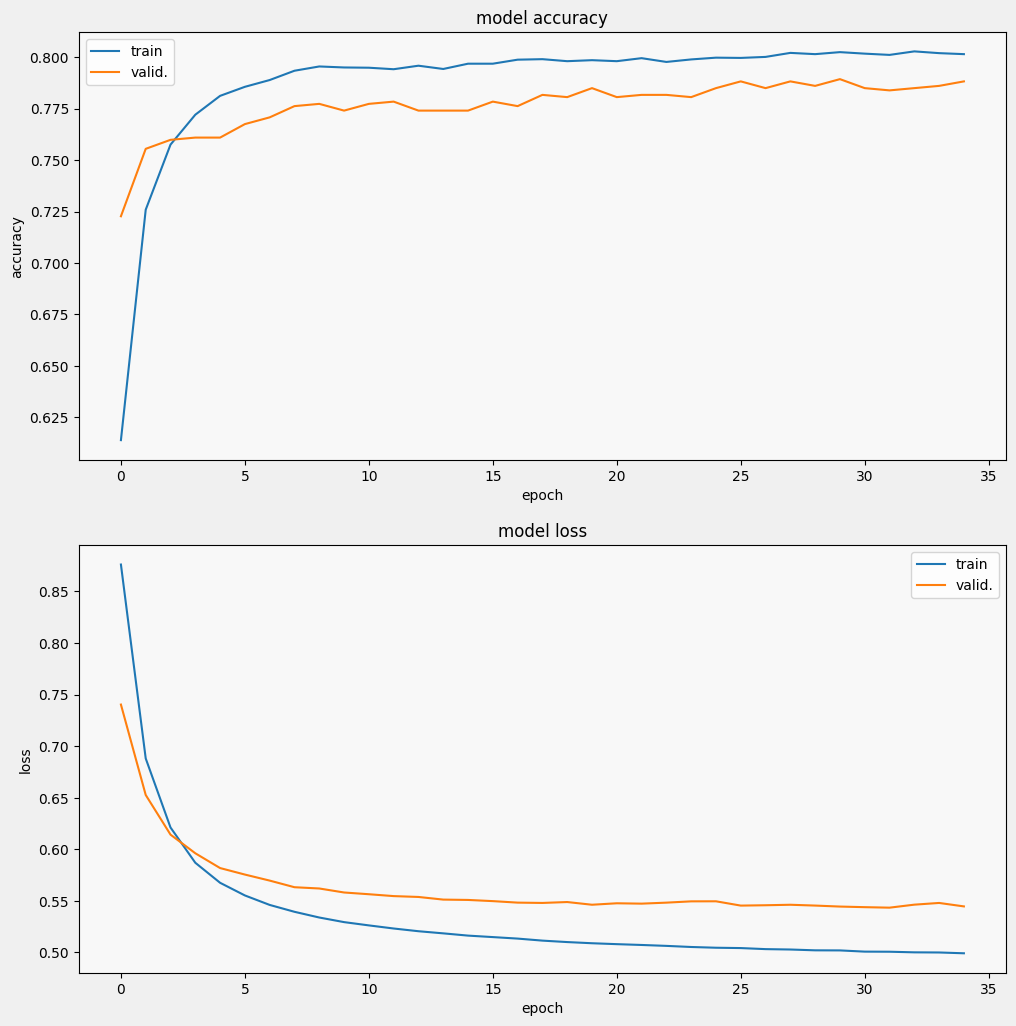

In [9]:
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

## Evaluate the model

And let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [10]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print('%s: %.3f' % (name, value))

4/4 - 0s - loss: 0.5376 - accuracy: 0.7897 - 336ms/epoch - 84ms/step


loss: 0.538
accuracy: 0.790


We can see that the loss quickly decreases while especially the accuracy rapidly increases. Let's plot some examples to check how the prediction relates to the true labels:

In [11]:
prediction_dataset = next(iter(test_data.batch(20)))

prediction_texts = [ex.numpy().decode('utf8') for ex in prediction_dataset[0]]
prediction_labels = [label2str(x) for x in prediction_dataset[1]]

predictions = [
    label2str(x) for x in np.argmax(model.predict(prediction_texts), axis=-1)]


pd.DataFrame({
    TEXT_FEATURE_NAME: prediction_texts,
    LABEL_NAME: prediction_labels,
    'prediction': predictions
})

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 124ms/step


string       label  prediction
0   The diffraction grating, LED, and split detect...  background      method
1   Our ideas are based on a previous paper [4] de...  background      method
2   Our finding is consistent with the literature ...      result      result
3   Test scores from each of the cognitive domains...      method      method
4   The optimization algorithm was set to maximize...      method      method
5   To quantify the extent of substitution saturat...      method      method
6   Examples of gesture control are based on the e...      method      method
7   The identification of these features has been ...      method  background
8   Postulated mechanisms for observed effects of ...  background  background
9   The right inferior phrenic artery is the most ...  background  background
10  [8] presented an approach for estimating the t...  background      method
11  Similar structures were observed in M10 cells ...      result      method
12  Cytotoxic effects of cobalt chloride were repo...  background  background
13  However, prolonged incubation of latex enzyme ...  background  background
14  …and travels great distances, resulting in a s...  background  background
15  The images fused using region selection; MSD, ...      method      method
16  These findings were expected, as EMG activity ...      result  background
17  The model has been extended to both 2D and 3D ...      method  background
18  Therefore, many authors claim comprehensive nu...  background      method
19  Similar to Ab40, IAPP-GI populates an aggregat...  background  background

We can see that for this random sample, the model predicts the correct label most of the times, indicating that it can embed scientific sentences pretty well.

# What's next?

Now that you've gotten to know a bit more about the CORD-19 Swivel embeddings from TF-Hub, we encourage you to participate in the CORD-19 Kaggle competition to contribute to gaining scientific insights from COVID-19 related academic texts.

* Participate in the [CORD-19 Kaggle Challenge](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge)
* Learn more about the [COVID-19 Open Research Dataset (CORD-19)](https://api.semanticscholar.org/CorpusID:216056360)
* See documentation and more about the TF-Hub embeddings at https://tfhub.dev/tensorflow/cord-19/swivel-128d/3
* Explore the CORD-19 embedding space with the [TensorFlow Embedding Projector](http://projector.tensorflow.org/?config=https://storage.googleapis.com/tfhub-examples/tensorflow/cord-19/swivel-128d/3/tensorboard/projector_config.json)